In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from scipy.ndimage import convolve
import matplotlib.animation as animation
import warnings
import scipy

In [10]:
params = { #parameters relevant for the equations
    "Nh":              10,
    "N0":              10,
    "R0":               8,
    "M":                1, #Also L
    "D":                3, #Unused
    "dc":               5, #Unused
    "mu":             0.1, 
    "gamma_shape":     20, 
}
sim_params = { #parameters relevant for the simulation (including Inital Valuess)
    "xdomain":         10,
    "dx":               1,
    "t0":               0, 
    "tf":              10,
    "dt":               1,
    "noise_mean":       0,
    "noise_std":      0.1,
    "initial_mean": [0,0],
    "initial_var":      5,
}

In [11]:
x_range = sim_params["xdomain"] #Initialize the spaces
dx = sim_params["dx"]
x_linspace = np.arange(-x_range, x_range, dx)
x_size = np.size(x_linspace)
sim_params["x_size"] = x_size

t_size = (sim_params["tf"]-sim_params["t0"])/sim_params["dt"]

s = np.zeros([x_size, x_size], dtype=int)
n = np.zeros([x_size, x_size], dtype=int) 
nh = np.zeros([x_size, x_size], dtype=int) #nh(x,t) = Nh*h(x,t) there should be a total of Nh*M elements 
coordmap = np.meshgrid(x_linspace, x_linspace) #coordmap is kinda stupid since we are not in any real space
c = nh.copy() # c is unused (supposed to be coverage)

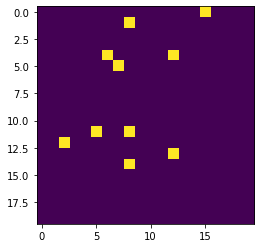

In [12]:
n0 = np.zeros(n.size, dtype=int) #Initial value of n0, initialized with a gaussian distributed

N0 = int(params["N0"])
initial_position = sim_params["initial_mean"]
initial_var = sim_params["initial_var"]

x_map = coordmap[0]
y_map = coordmap[1]

rsqrd = (x_map-initial_position[0])**2 + (y_map-initial_position[0])**2

p0 = np.exp(-rsqrd/(2*(initial_var**2)))
p0 = p0/np.sum(p0) # initial prob distribution for n: Gaussian dist

p0 = p0.ravel()

for i in range(N0):
    index = np.random.choice(n.size, p=p0) #Should really have a better way of doing this, this is extremely slow: maybe MPI?
    n0[index] += 1

n = copy.deepcopy(n0.reshape(n.shape)) #Make a deepcopy to seperate the two functions
plt.figure()
plt.imshow(n)

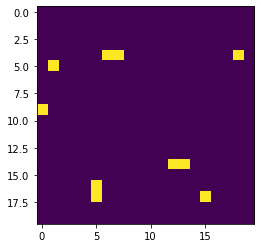

In [13]:
nh0 = np.zeros(nh.size, dtype=int) #Similarly, this is the initial value for nh

Nh = int(params["Nh"])
M = int(params["M"])
initial_position = sim_params["initial_mean"]
initial_var = 10*sim_params["initial_var"] #just 10 times the variance of n0, maybe change this?

x_map = coordmap[0]
y_map = coordmap[1]

rsqrd = (x_map-initial_position[0])**2 + (y_map-initial_position[0])**2

p0 = np.exp(-rsqrd/(2*(initial_var**2)))
p0 = p0/np.sum(p0) # initial prob distribution for n: Gaussian dist

p0 = p0.ravel()

for i in range(Nh*M):
    index = np.random.choice(nh.size, p=p0) #similarly, this is really slow
    nh0[index] += 1

nh = copy.deepcopy(nh0.reshape(nh.shape))
plt.figure()
plt.imshow(nh)

In [15]:
def coverage(h):
    return h/params["M"] #I know this looks stupid but the coverage is not necessarily just a scale

def fitness(nh):
    R0 = params["R0"]
    M = params["M"]
    Nh = params["Nh"]

    h = nh/Nh
    eff_R0 = R0*(1-coverage(h))**M
    res = np.log(eff_R0, out=np.zeros_like(eff_R0), where=(eff_R0!=0))  # I'm not convinced this is right, the log(0) = 0 as 
                                                                        # is might not be correct but R0 should not be smaller than 1 
    # check = R0*(1-coverage(h))**M
    # out = np.log(R0*((1-coverage(h))**M)) # This just fails as log(0) happens regularly
    return res

In [16]:
def virus_growth(n, f):
    dt = sim_params["dt"]
    return np.random.poisson((1+f*dt)*n) #growth rate is (1+fdt)n as normal really

def num_mutants(n, mu = params["mu"], dt = sim_params["dt"]):
    p = 1-np.exp(-1*mu*dt)
    return np.random.binomial(n, p) #   so this is really prob of finding k mutation in n possible virus with prob p in 1-e^-mudt
                                    #   so p to not mutated is really e^-mu*dt

def num_mutation(mu, dt = sim_params["dt"]):
    out = np.random.poisson(mu*dt)
    if out >= 1 :
        return out #This is what mu, is the average rate of mutation
    else:
        return num_mutation(mu) #conditioned as to have at least one mutation

def mutation_jump(m, dx = sim_params["dx"], shape_param = params["gamma_shape"]):
    jump = np.zeros(2)
    mean = 2*dx
    theta = mean/shape_param
    
    for i in range(m):
        jump = jump + np.random.gamma(shape_param, theta, size=2) #The distribution of jump is a sum of gamma distribution. 

    jump = np.round(jump)
    return jump

def immunity_gain(nh, n): 
    return nh + n # to gain immunity you need some amount infected

def immunity_loss(nh, n):
    N = np.sum(n)
    checksum = np.sum(nh)

    for i in range(N):
        indexes = np.argwhere(nh > 0)
        index = np.random.choice(indexes.shape[0]) # Choose random spots uniformly to loose immunity

        nh[indexes[index, 0], indexes[index, 1]] -= 1 #There is a race condition, don't fuck with this
    
    if np.any(nh<0):
        raise ValueError("Immunity is negative")
    elif np.sum(nh) != checksum - N :
        raise ValueError("In and out total value don't match")
    

    return nh

In [17]:
def mutation(n): #this is the joined function for the mutation step
    checksum = np.sum(n)

    mu = params["mu"]
    dt = sim_params["dt"]
    dx = sim_params["dx"]
    shape_param = params["gamma_shape"]

    mutation_map = num_mutants(n, mu) # The mutation maps tells you how many virus have mutated at each location
    x_ind, y_ind = np.nonzero(mutation_map) #finding out where the mutations happends
    num_mutation_sites = x_ind.size 
    
    for i in range(num_mutation_sites): 
        num_mutants_at_site = mutation_map[x_ind[i], y_ind[i]] # unpacking the number of mutated virus
        n[x_ind[i], y_ind[i]] -= num_mutants_at_site #first remove all the virus that moved

        for j in range(num_mutants_at_site): #Find out where those virus have moved to
            num_mutation_at_site = num_mutation(mu, dt) #Sampling how many single mutation for a single virus (num of jumps) 
            jump = mutation_jump(num_mutation_at_site, dx, shape_param) #Sampling the jump

            try:
                new_x_loc = (x_ind[i] + jump[0]).astype(int)
                new_y_loc = (y_ind[i] + jump[1]).astype(int)
                n[new_x_loc, new_y_loc] += 1
            except IndexError: #Array Out of Bounds
                if new_x_loc >= n.shape[0]:
                    new_x_loc = -1 #lmao this is gonna be a pain in cpp
                if new_y_loc >= n.shape[1]:
                    new_y_loc = -1
                n[new_x_loc, new_y_loc] += 1

    if np.sum(n) != checksum : #Should conserve number of virus/infection
        raise ValueError('mutation changed total number of n')
    elif np.any(n<0): #Should definitely not be negative
        raise ValueError('mutation made n negative')

    return n

In [23]:
nh = nh0.reshape(nh.shape)
n = n0.reshape(n.shape) # In time 

t_start = sim_params["t0"] #Time parameters
t_stop = sim_params["tf"]
t_step = sim_params["dt"]

frames_n = [] #Store the frames as gifs
frames_nh = []
frames_f = []

N = []

for t in np.arange(t_start, t_stop, t_step):

    f = fitness(nh)
    n = virus_growth(n, f) #update n
    n = mutation(n)

    nh_old = copy.deepcopy(nh)
    nh = immunity_gain(nh, n) #update nh
    nh = immunity_loss(nh, n)

    # print(np.any(nh-nh_old != 0))
    
    frames_nh.append([nh])
    frames_f.append([f])
    frames_n.append([n])
    N.append([np.sum(n)])


In [ ]:
def makeGif(frame_stack, name):
    fig = plt.figure()

    animation_frames = []
    for frame in frame_stack:
        frame = np.squeeze(frame)
        animation_frames.append([plt.imshow(frame, animated=True)])

    ani = animation.ArtistAnimation(
        fig, animation_frames, interval=50, blit=True, repeat_delay=1000)
    ani.save(name + ".gif")

    return 1

1

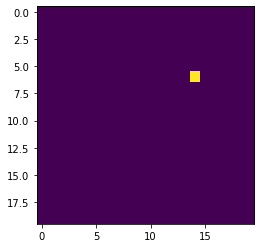

In [33]:
makeGif(frames_nh, "discrete_nh")

In [225]:
def update(n, nh):
    f = fitness(nh)
    n = virus_growth(n, f)

    n = mutation(n)
    nh = immunity_gain(nh, n)
    nh = immunity_loss(nh, n)
    # plt.imshow(n)
    return n, nh